In [2]:
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.stats import norm
np.random.seed(0)
import seaborn as sns
import random as rnd
import csv
import random
import math
import operator
import copy

# Load and Preprocess Dataset

In [3]:
data= pd.read_csv("/home/aklesh/Documents/SMAI_A2/SMAI_2019201073/weather.csv")
data = data.drop(["Formatted Date"],axis=1)
data = data.fillna('0')

In [376]:
test_data= pd.read_csv("/home/aklesh/Documents/SMAI_A2/SMAI_2019201073/weather_test.csv")
test_data = test_data.drop(["Formatted Date"],axis=1)
test_data = test_data.fillna('0')

In [4]:
df = pd.read_csv("/home/aklesh/Documents/SMAI_A2/SMAI_2019201073/weather.csv")
df = df.fillna('clear')
df['EDTdate'] = pd.to_datetime(df['Formatted Date'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df['Hour'] = df['Hour'].astype('category')
data = df.drop(["Formatted Date","EDTdate"],axis=1)

In [5]:
data

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Hour,AMorPM,Weekday
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,Partly cloudy throughout the day.,20,pm,Fri
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,Partly cloudy throughout the day.,21,pm,Fri
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,Partly cloudy throughout the day.,22,pm,Fri
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,Partly cloudy throughout the day.,23,pm,Fri
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,Partly cloudy throughout the day.,0,am,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77280,Partly Cloudy,rain,28.838889,27.850000,0.32,12.2038,21,16.1000,1014.07,Partly cloudy starting in the morning.,14,pm,Fri
77281,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31,16.1000,1014.36,Partly cloudy starting in the morning.,15,pm,Fri
77282,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20,15.5526,1015.16,Partly cloudy starting in the morning.,16,pm,Fri
77283,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30,16.1000,1015.66,Partly cloudy starting in the morning.,17,pm,Fri


In [6]:
data = np.array(data)
data_list = []
x = 0
for i in range(data.shape[1]):
    n_data = pd.DataFrame(data[:,i])
    if (isinstance(n_data[0][0], str) or i==10):
        n_data = pd.get_dummies(n_data)
        print(n_data.shape)
    else:
        x+=1
        dict={str(i):data[:,i]}
        n_data = pd.DataFrame(dict)
    data_list.append(n_data)
data = pd.concat(data_list,axis=1)

(77285, 26)
(77285, 3)
(77285, 214)
(77285, 24)
(77285, 2)
(77285, 7)


In [7]:
cols = data.columns
col_idx = list(enumerate(cols))
for val in col_idx:
    data.rename(index=str, columns={val[1]: val[0]}, inplace=True)  

In [8]:
data.shape

(77285, 283)

# For Test Data Only

In [31]:
#std_data = (data - data.mean())/data.std()
X_test = data.drop([27],axis=1)
std_X_test = (X_test - X_test.mean())/X_test.std()
Y_test = data[[27]]

std_X_test[27] = Y_test

In [36]:
new_data = {}
for i in range(283):
    new_data[i]=np.array([])
j=0
for i in range(283):
    if (i>=23 and i<=25) or i==249:
        new_data[i] = np.zeros(std_X_test.shape[0],dtype=np.int32)
    else:
        new_data[i] = np.array(std_X_test[j])
        j+=1
new_data = pd.DataFrame(new_data)
#print(new_data[30])

In [54]:
new_data.shape

(19168, 283)

# Multivariate Linear regressior

In [9]:
class MLinearRegressior:
    def __init__(self,alpha,iterations):
        self.alpha=alpha
        self.maxiter=iterations
    def costfunc(self,X,Y,theta,EFun):
        m=X.shape[0]
        error=(np.dot(X,theta)-Y)
        if(EFun=="MSE"):
            cost=(1/m) * np.dot(error.T,error)
        elif(EFun=="MAE"):
            cost=np.mean(abs(error))
        else:
            error = -error
            for i in range(error.shape[0]):
                if(Y[i]==0.0):
                    error[i]=error[i]/0.01
                else:
                    error[i]=error[i]/Y[i]
            cost=np.mean(error) * 100
        return cost,error
    def gradient_descend(self,X,Y,theta,EFun):
        cost_arr = np.zeros(self.maxiter)
        m = X.shape[0]
        for i in range(self.maxiter):
            cost,error=self.costfunc(X,Y,theta,EFun)
            if(EFun=='MSE'):
                theta = (theta - (self.alpha*(1/m)*np.dot(X.T,error)))
            else:
                theta = (theta - (self.alpha*(1/m)*(np.dot(X.T,np.sign(error)))))
            cost_arr[i]=cost
            print(i)
        return theta,cost_arr
        
    def run(self,data,theta,EFun):
        feature_names = []
        for i in range(len(data.columns)):
            if(i!=30):
                feature_names.append(i)
        X = data[feature_names]
        Y = data[[30]]
        X = (X-X.mean())/X.std()
        X = np.c_[np.ones(X.shape[0]),X]
        X = np.array(X)
        Y = np.array(Y)
        theta = np.zeros(shape = (X.shape[1],1))
        #initial_cost,_ = self.costfunc(X,Y,theta,EFun)
        theta,cost_arr = self.gradient_descend(X,Y,theta,EFun)
        #final_cost,_ = self.costfunc(X,Y,theta)
        #print("With theta {0} the final cost of model is {1}".format(theta,final_cost))
        return theta,cost_arr
    def predict(self,data,theta):
        feature_names = []
        for i in range(len(data.columns)):
            if(i!=30):
                feature_names.append(i)
        X = data[feature_names]
        Y = data[[30]]
        X = np.c_[np.ones(X.shape[0]),X]
        X = np.array(X)
        Y = np.array(Y)
        mse,_ = self.costfunc(X,Y,theta,"mse")
        return np.dot(X,theta),mse

In [63]:
LGM = MLinearRegressior(0.01,2000)
C_theta,cost_arr = LGM.run(data,theta,"MSE")
C1_theta,cost_arr1 = LGM.run(data,theta,"MAE")
C2_theta,cost_arr2 = LGM.run(data,theta,"MAPE")

In [14]:
#new_theta = np.load("theta_val.npy")
#opt_theta = C_theta
#opt_theta1 = C_theta 
#opt_theta2 = C_theta

In [68]:
prediction,mse = LGM.predict(new_data,opt_theta2)

In [69]:
mse

18.624614389651576

In [86]:
prediction

array([[14.886165820112799],
       [18.147530371868125],
       [8.591372116084202],
       ...,
       [15.419302734574249],
       [13.80262549356317],
       [20.734047384772413]], dtype=object)

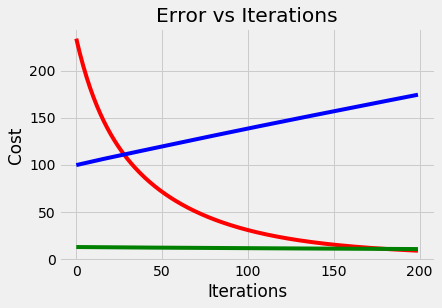

In [150]:
fig, ax = plt.subplots()
ax.plot(np.arange(200), cost_arr, 'r')
ax.plot(np.arange(200), cost_arr1, 'g')
ax.plot(np.arange(200), cost_arr2, 'b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs Iterations')
plt.style.use('fivethirtyeight')

# Analysis of Experiment

## Behaviour of theta w.r.t. MSE,MAE and MAPE

In [27]:
C_theta

array([[10.333417918062361],
       [-0.01418480854251187],
       [-0.006511390313282729],
       [0.046728335391978064],
       [0.00010645503515021947],
       [-0.0024842238945086467],
       [-0.0003877155100456619],
       [-0.1558308266028316],
       [0.001809466367277171],
       [-0.008255302676118436],
       [0.04075851984370269],
       [0.0317826190372264],
       [0.05848609618643667],
       [-0.04259989796250759],
       [0.08931607286598356],
       [0.05115570306548699],
       [0.05700885958395278],
       [-0.0033694224939292204],
       [0.04057287370015086],
       [-0.09623136528603513],
       [0.15350212083370685],
       [-0.0016134388796533704],
       [-0.007463472440275581],
       [0.020726712031024053],
       [0.00735416327414434],
       [0.00042618068925353073],
       [-0.004461750070252386],
       [0.8514121869412933],
       [-0.9255355843617687],
       [5.53412586840063],
       [-1.9377929802891252],
       [-0.0784626775787116],
       [0.0505

In [28]:
C1_theta

array([[1.6969406741282265],
       [-0.0029155939208554034],
       [0.0010901344072069153],
       [-0.00939246012645003],
       [0.00835254924710468],
       [0.0012944513421465252],
       [0.012821843853945058],
       [-0.02564903523143616],
       [0.0010901344072061674],
       [0.00607078989309985],
       [0.005972032631469043],
       [0.0037766051365318394],
       [0.009189798561881403],
       [-0.15678775730597042],
       [0.005972032631467802],
       [0.002884336503070712],
       [0.003930840687902724],
       [0.007863666064205155],
       [0.06071237807473145],
       [-0.05012167462817529],
       [0.08035512146485507],
       [0.003270572501529094],
       [0.0026703594314958804],
       [0.00030978333129536885],
       [0.006167968619497571],
       [0.0009275301260201099],
       [0.007554970335498497],
       [0.653077297165592],
       [-0.671213843846784],
       [0.5031337305671317],
       [-0.16953099383747597],
       [0.06334342977340217],
       [0.03

In [29]:
C2_theta

array([[-1.9462511483470266],
       [-0.0012533185254211907],
       [-0.00019333994215528462],
       [0.004144052566604336],
       [-0.003201542088952604],
       [0.004475950019290907],
       [-0.003397807953282605],
       [0.000499558018454868],
       [-0.00019333994215466602],
       [-0.0010766802322796963],
       [-0.0010591652147828512],
       [-0.0006697968744407501],
       [-0.0016298495953082969],
       [0.026387212350621237],
       [-0.0010591652147739173],
       [-0.0005115492630757327],
       [-0.0006971512010080443],
       [-0.0013946543948805648],
       [-0.004231623060535665],
       [0.010948962610848335],
       [-0.01912092773820666],
       [-0.0005800498489672211],
       [-0.00047359952554143],
       [-0.00038668738957931784],
       [-0.0010939152899409488],
       [0.0012941248777474303],
       [-0.0013399059033690833],
       [-0.14756771100259847],
       [0.1514215495952376],
       [-0.0702955473833276],
       [0.03579692047736474],
       

In [23]:
print(np.sign(C_theta.T))

[[1 -1 -1 1 1 -1 -1 -1 1 -1 1 1 1 -1 1 1 1 -1 1 -1 1 -1 -1 1 1 1 -1 1 -1
  1 -1 -1 1 1 -1 1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 -1 -1 1 1 -1 -1 -1 1 -1 -1
  -1 -1 -1 -1 -1 1 -1 -1 1 1 1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 1
  -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 1 1 1 -1 1 1
  -1 1 -1 -1 -1 -1 1 -1 1 1 -1 -1 -1 -1 1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1
  1 -1 -1 1 -1 1 -1 -1 -1 -1 -1 -1 1 -1 -1 1 -1 1 1 -1 -1 -1 -1 -1 -1 1 1
  1 -1 1 1 1 1 1 -1 1 1 1 1 -1 -1 1 -1 1 -1 1 1 1 1 1 -1 1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 1 -1 -1 1 1 1 1 -1 1 -1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 -1 1 1
  -1 -1 1 -1 1 1 -1]]


In [24]:
print(np.sign(C1_theta.T))

[[1 -1 1 -1 1 1 1 -1 1 1 1 1 1 -1 1 1 1 1 1 -1 1 1 1 1 1 1 1 1 -1 1 -1 1
  1 1 -1 1 -1 1 1 -1 -1 1 1 -1 -1 1 1 -1 -1 1 1 1 -1 -1 1 -1 1 -1 1 -1 -1
  1 -1 1 -1 1 1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1
  -1 1 1 1 -1 -1 1 -1 -1 -1 -1 -1 -1 1 1 1 1 1 -1 1 1 -1 1 1 -1 -1 1 1 -1
  1 1 -1 -1 1 -1 1 1 -1 -1 -1 -1 1 -1 1 1 -1 1 1 1 1 -1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 -1 1 1 -1 1 1 1 1 1 1 1 -1 1 1 1 1 1 -1 -1 1 1 1 1 -1 -1
  -1 1 1 -1 1 1 1 -1 1 1 1 1 1 -1 -1 1 1 1 -1 1 1 -1 1 1 1 1 1 1 1 -1 1
  -1 -1 1 1 1 1 1 -1 -1 1 -1 1 1 1 1 1 1 1 1 -1 1 1 1 1 1 1 1 1 1 1 -1 1
  1 -1 1 1 1 1 1]]


In [25]:
print(np.sign(C2_theta.T))

[[-1 -1 -1 1 -1 1 -1 1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 1
  -1 -1 1 -1 1 -1 -1 -1 1 1 -1 -1 -1 1 1 -1 -1 1 -1 -1 -1 1 1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 1 1 1 -1 1 -1 1 1 1 1 1 1 1
  -1 1 1 -1 -1 1 1 -1 -1 -1 1 1 1 -1 1 1 1 1 1 -1 -1 -1 -1 -1 1 -1 -1 1
  -1 -1 -1 -1 -1 -1 1 -1 -1 1 1 -1 -1 -1 -1 -1 1 1 -1 -1 1 -1 -1 -1 1 -1
  -1 1 1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 1 -1 -1 -1 -1 1 1 1 1 -1 1 1 -1 -1 1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 -1 1 -1 1 -1
  -1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 -1 1 -1 1
  -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1]]


In [ ]:
df = pd.read_csv("/home/aklesh/Documents/SMAI_A2/SMAI_2019201073/weather.csv")
df = df.fillna('clear')
df['EDTdate'] = pd.to_datetime(df['Formatted Date'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df['Hour'] = df['Hour'].astype('category')
data = df.drop(["Formatted Date","EDTdate"],axis=1)